In [14]:
%matplotlib inline
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from pathlib import Path
import random
from tqdm import tqdm
from copy import deepcopy
from pulp import *

#set random seed
random.seed(42)

def data_loader(path):
    return pd.read_csv(path, index_col=0, low_memory=False)

# needs to be changed to the actual location
PATH = Path(r'C:\Users\Ferenc Fodor\Desktop\DTU\deep-learning-fpl') / 'final_data.csv'

POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
POSITION_LIMITS = {'GK':1, 'DEF':5, 'MID':5, 'FWD':3}
SEASONS = np.array(['2017-18', '2018-19', '2019-20', '2020-21'])
POS = ['GK1', 'DEF1', 'DEF2', 'DEF3', 'DEF4', 'MID1', 'MID2', 'MID3', 'MID4', 'FWD1', 'FWD2']
POS_IDX = [i for i in range(0,11)]

In [15]:
def players_by_position(df_squad):    
    df_mapping = pd.DataFrame({
        'position': ['GK', 'DEF', 'MID', 'FWD'],
    })
    sort_mapping = df_mapping.reset_index().set_index('position')

    _df_squad = df_squad.sort_values(by='position')
    _df_squad['pos_num'] = _df_squad['position'].map(sort_mapping['index'])
    players = _df_squad.sort_values(by='pos_num')['element'].values
    return list(players)


def select_optimal_squad(df_gw, maximize='selected', ret_idx=True):
    data = df_gw.copy()

    player = [str(i) for i in range(data.shape[0])]
    point = {str(i): data[maximize].values[i] for i in range(data.shape[0])} 
    cost = {str(i): data['value'].values[i] for i in range(data.shape[0])}
    gk = {str(i): 1 if data['position'].values[i] == 'GK' else 0 for i in range(data.shape[0])}
    defe = {str(i): 1 if data['position'].values[i] == 'DEF' else 0 for i in range(data.shape[0])}
    mid = {str(i): 1 if data['position'].values[i] == 'MID' else 0 for i in range(data.shape[0])}
    stri = {str(i): 1 if data['position'].values[i] == 'FWD' else 0 for i in range(data.shape[0])}
    xi = {str(i): 1 for i in range(data.shape[0])}

    prob = LpProblem("Fantasy Football",LpMaximize)
    player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)

    # objective function
    prob += lpSum([point[i]*player_vars[i] for i in player]), maximize

    # constraint
    prob += lpSum([player_vars[i] for i in player]) == 11, "Total 11 Players"
    prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 830.0, "Total Cost"
    prob += lpSum([gk[i] * player_vars[i] for i in player]) == 1, "1 GK"
    prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 5, "5 DEF"
    prob += lpSum([mid[i] * player_vars[i] for i in player]) <= 5, "5 MID"
    prob += lpSum([stri[i] * player_vars[i] for i in player]) <= 3, "3 STR"
    
    #minimum number of players
    prob += lpSum([defe[i] * player_vars[i] for i in player]) >= 3, "3 DEF"
    prob += lpSum([mid[i] * player_vars[i] for i in player]) >= 2, "2 MID"
    prob += lpSum([stri[i] * player_vars[i] for i in player]) >= 1, "1 STR"



    # solve
    status = prob.solve()

    include = []
    for k in player_vars.keys():
        include.append(player_vars[k].varValue)
    data['include'] = np.array(include)
    
    if ret_idx:
        return players_by_position(data[data['include'] == 1])
    else:
        return data[data['include'] == 1] 

In [16]:
class Gameweek:
    def __init__(self, season, gw_id):
        self.id = gw_id
        self.df = season.df[season.df['GW'] == gw_id]
        self.history = season.df[season.df['GW'] < gw_id]

class Seasons:
    def __init__(self, data):
        self.df = data
        self.df['MA3'] = self.generate_moving_average_per_player(3)
        self.df['MA5'] = self.generate_moving_average_per_player(5)
        self.df['MA7'] = self.generate_moving_average_per_player(7)
        self.df['MA10'] = self.generate_moving_average_per_player(10)

        self.FORMATIONS = [[1,5,4,1],[1,5,3,2],[1,5,2,3],[1,4,5,1],[1,4,4,2],[1,4,3,3],[1,3,5,2],[1,3,4,3]]
        self.FORMATIONS_STR = [' '.join(np.array(f, dtype=str)) for f in self.FORMATIONS]
        self.POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
        self.POSITION_LIMITS = {'GK':2, 'DEF':5, 'MID':5, 'FWD':3}

        self._load_environment()

    def _load_environment(self):
        self.gameweeks = []
        for i, gw in enumerate(sorted(self.df['GW'].unique())):
            self.gameweeks.append(Gameweek(self, gw_id=i+1))
            
    def generate_moving_average_per_player(self, rolling=3, column_by='total_points'):
        ma = self.df[['element', 'GW', 'total_points']].copy()
        ma = ma.groupby(['element']).rolling(rolling, min_periods=2)[column_by].mean().reset_index()
        ma.rename({'total_points': f'MA{rolling}'}, axis=1, inplace=True)
        ma.set_index('level_1', inplace=True)
        ma.fillna(0, inplace=True)
        return ma[f'MA{rolling}']


formation = '1 5 4 1'
dummy_team = [12,232,239,255,146,110,390,37,302,254,164]

season = Seasons(data)
season.df[season.df['name'] == 'Mohamed Salah'][['GW', 'total_points', 'MA5', 'MA10']].head(10)

,GW,total_points,MA5,MA10
268,1,11,0.000000,0.000000
658,2,1,6.000000,6.000000
1053,3,11,7.666667,7.666667
1457,4,1,6.000000,6.000000
1868,5,10,6.800000,6.800000
2280,6,7,6.000000,6.833333
2693,7,2,6.200000,6.142857
3107,8,3,4.600000,5.750000
3523,9,7,5.800000,5.888889
3941,10,4,4.600000,5.700000


In [18]:
class TransferLog:
    def __init__(self):
        self.log = []
        
    def update(self, log):
        self.log.append(log)
    

class Team:
    def __init__(self, df_gw, players):
        self.gw = df_gw['GW'].unique()[0]
        self.df_gw = df_gw
        self.mapping = {p: players[i] for i, p in enumerate(POS_IDX)}
        self.value = self.get_value()
        self.money_left = 830 - self.value
        self.log = TransferLog()

        
    def transfer(self, pos_id, pick_id, select_by):
        money_back = self._p_price(pos_id)
        avail_price = self.money_left + money_back  
        
        if pick_id == 0:
            by = 'MA3'
        elif pick_id == 1:
            by = 'MA5'
        elif pick_id == 2:
            by = 'MA10'
        else:
            by = 'selected'
        
        avail_players = self.get_player_list(pos_id, avail_price, by)
        
        old_player = self.mapping[pos_id]
        new_player = avail_players.iloc[0]['element']
        self.mapping[pos_id] = new_player

        new_cost = avail_players.iloc[0]['value']
        profit = money_back - new_cost
        
        self.value = self.value + profit
        self.money_left = self.money_left + profit
        log = [self.gw, by, POS[pos_id], old_player, new_player, money_back, new_cost, profit, self.money_left, list(avail_players.head(3)['element'].values)]
        self.log.update(log)
        return self.p()

    def _pos_map(self, pos_id):
        return POS[pos_id]
        
    def p(self):
        return list(self.mapping.values())
    
    def get_names(self):
        return self.df_gw.set_index('element').loc[self.p()]['name'].values
    
    def _p_price(self, pos_id):
        return self.df_gw.set_index('element').loc[self.mapping[pos_id], 'value'].max()
    
    def get_player_list(self, pos_id, avail_price, category):
    
        df = self.df_gw[self.df_gw['position'] == self._pos_map(pos_id)[:-1]]
        
        #filter value
        df = df[df['value'] <= avail_price].sort_values(category, ascending=False)
        df = df.query(f'element not in {self.p()}')
        #print(df[['name', 'value', category]].head())
        return df
        
    
    def get_value(self):
        return self.df_gw.set_index('element').loc[self.p(),'value'].sum()

In [19]:
df_mapping = pd.DataFrame({'position': ['GK', 'DEF', 'MID', 'FWD']})
sort_mapping = df_mapping.reset_index().set_index('position')

DUMMY_TEAM = select_optimal_squad(season.gameweeks[1].df)

#sort dummy team players by position
_df_squad = season.df.query(f'GW == 1 and element in {DUMMY_TEAM}').sort_values(by='position')
_df_squad['pos_num'] = _df_squad['position'].map(sort_mapping['index'])
players = _df_squad.sort_values(by='pos_num')['element'].values

#define dummy team
t = Team(season.df[season.df['GW'] == 1], players)
print(t.mapping)
print(t.get_names())

#perform some transfers
t.transfer(0, 0, 'transfers_balance')
t.transfer(1, 2, 'transfers_balance')
t.transfer(3, 1, 'transfers_balance')


print(t.mapping)
print(t.get_names())

#check the transfer log
print('Transfer Log:\n', t.log.log)

{0: 172, 1: 119, 2: 174, 3: 423, 4: 628, 5: 80, 6: 411, 7: 518, 8: 545, 9: 612, 10: 621}
['David De Gea' 'Charlie Daniels' 'David Luiz Moreira Marinho'
 'Kyle Walker' 'Ryan Bertrand' 'Bamidele Alli' 'Kevin De Bruyne'
 'Mohamed Salah' 'Nemanja Matic' 'Roberto Firmino' 'Romelu Lukaku']
{0: 19, 1: 2, 2: 174, 3: 479, 4: 628, 5: 80, 6: 411, 7: 518, 8: 545, 9: 612, 10: 621}
['Adrián San Miguel del Castillo' 'Aaron Cresswell'
 'David Luiz Moreira Marinho' 'Mason Holgate' 'Ryan Bertrand'
 'Bamidele Alli' 'Kevin De Bruyne' 'Mohamed Salah' 'Nemanja Matic'
 'Roberto Firmino' 'Romelu Lukaku']
Transfer Log:
 [[1, 'MA3', 'GK1', 172, 19, 55, 45, 10, 20, [19, 27, 730]], [1, 'MA10', 'DEF1', 119, 2, 50, 50, 0, 20, [2, 479, 454]], [1, 'MA5', 'DEF3', 423, 479, 65, 45, 20, 40, [479, 454, 461]]]


In [20]:
import itertools

# defining the action space
ACTION_SPACE = {0: 'No Transfer'}
POS_IDX = [i for i in range(0,11)]

# actions 1-11: transfer 1 player (for every position)
idx = 1
for p in POS_IDX:
    for i in range(0,3):
        ACTION_SPACE[idx] = f"{p}-{i}"            
        idx+=1

'''
Preparation for multiple transfer action space. 
It does work, but it exponentially explodes the action space, 
and as I do not fully understand it yet, I did not include it in the report.
'''
# action combinations: 2 transfers
it = itertools.combinations(list(ACTION_SPACE.keys())[1:], 2)

# action combinations: 3 transfers
it2 = itertools.combinations(list(ACTION_SPACE.keys())[1:], 3)

# combinations list
acts = [x for x in it]
acts = acts + [x for x in it2]

#for act in acts:
#    ACTION_SPACE[idx] = act
#    idx += 1 

In [21]:
# one-hot encoder for the states
def one_hot(i, l):
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

# one-hot encoder for the states
def one_hot_new(state_ids, n_inputs):
    states = np.array([range(0, 798)])
    for i, s in enumerate(state_ids):
        _s = np.array([*"{0:b}".format(s)]).astype(float)
        if len(_s) < n_inputs:
            dummy = np.zeros(n_inputs-len(_s))
            _s = np.concatenate((dummy, _s))
        states = np.vstack((states, _s))
    return states[1:]


class State:
    def __init__(self, team, data):
        self.team = team
        self.squad = self.team.p()
        self.id, self.encoding = self._encode(data)
        
    def __sub__(self, other):
        return len(set(other.squad) - set(self.squad))
    
    def _encode(self, data):
        '''
        One-hot encoding the state:
        0 - inactive
        1 - active
        
        bytes 0-4 - season id
        bytes 5-43 - gameweek id
        bytes 44 - 800 - player ids
        '''
        #select current gameweek
        current_data = data[data['GW'] == self.team.gw]

        #encode season
        n_seasons = len(SEASONS)
        current_season = np.where(SEASONS == current_data.iloc[0]['season'])[0][0]
        season_encoded = one_hot([current_season], n_seasons).sum(axis=0)

        #encode gameweek
        n_gw = self.team.gw - current_season * 38
        gw_encoded = one_hot([n_gw-1], 38).sum(axis=0)

        #encode current squad
        n_players = len(data.name.unique())
        players = self.team.p()
        players_encoded = one_hot(players, n_players).sum(axis=0)

        #define state id
        state_encoding = np.r_[season_encoded, gw_encoded, players_encoded]
        state_id = int(''.join(state_encoding.astype(int).astype('str')), 2)
        return state_id, np.array([state_encoding])
        


    
        
        
class Environment:
    def __init__(self, data):
        self.season = Seasons(data)
        self.action_space = ACTION_SPACE
        
        _ = self.reset()
        #self.fill_action_space()
        
    def reset(self, gw=1):
        dummy_gw = self.season.df[self.season.df['GW'] == gw]
        dummy_team = select_optimal_squad(dummy_gw, maximize='selected')
        self.def_team = Team(dummy_gw, dummy_team)

        self.def_state = State(self.def_team, self.season.df)
        _ = self.load_state(self.def_state)
        self.state = self.def_state
        return self.state, self.def_team

    def describe(self):
        print(f'Current Gameweek: {self.current_gw}')
        
    def load_state(self, state):
        self.state = state
        self.current_gw = state.team.gw
        self.current_squad = state.squad
        
        if state.team.gw == len(self.season.df['GW'].unique()):
            return True
        else:
            return False
        
        
    def step(self, action_id, metric):
        _prev_state = deepcopy(self.state)
        team = _prev_state.team
        
        if action_id != 0:
            if action_id <= 34:
                # decode action from the action space
                pos_id, pick_id = self.action_space[action_id].split('-')

                # do the transfer
                try:
                    team.transfer(int(pos_id), int(pick_id), metric)

                except Exception as e:
                    pass
            else:
                actions_to_do = self.action_space[action_id]
                for action in actions_to_do:
                    pos_id, pick_id = self.action_space[action].split('-')

                    # do the transfer
                    try:
                        team.transfer(int(pos_id), int(pick_id), metric)

                    except Exception as e:
                        pass

        # update team for next round
        next_gw = _prev_state.team.gw + 1 
        team.gw = next_gw
        team.df_gw = self.season.df[self.season.df['GW'] == next_gw].groupby(['season', 'position', 'element', 'name']).mean().reset_index()
        
        # updated state
        new_state = State(team, self.season.df)

        done = self.load_state(new_state)
        
        reward = self.calculate_reward()
        transfer_penalty = _prev_state - new_state
            
        if next_gw - 1 == 0:
            transfer_penalty = 0
        
        if transfer_penalty > 1:
            reward = reward - (transfer_penalty - 1) * 4
        
        return new_state, reward, done, transfer_penalty

    def calculate_reward(self):
        future_df = self.season.gameweeks[self.current_gw-1].df
        r = future_df.query(f"element in {self.current_squad}")['total_points'].sum()
        return r
    
    def sample_action_space(self, n_samples=1, gw=None):
        return random.randint(0,len(ACTION_SPACE)-1)

In [22]:
env = Environment(data)
n_inputs = len(env.reset()[0].encoding[0])

In [27]:
#testing the environment
s, _ = env.reset(1)

new_state, reward, done, transfer_penalty = env.step(33, 'MA5')
print(new_state.id)

new_state.team.log.log

859548735488418715023753922815078573063853986111764402548715416457001485042560348782670948208637855749034602738175265988338906554203735861059683911324996839071707086761298067133194335313815770814395905486879623693195333650737728652400787456


[[1, 'MA10', 'FWD2', 621, 25, 115, 50, 65, 65, [25, 425, 441]]]

In [28]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

In [29]:
class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(DQN, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs)

        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
    
    def forward(self, x):
        return self.out(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [30]:
#load environment
env = Environment(data)

In [ ]:
import time
# train Deep Q-network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epsilon = 1.0
num_episodes = 300
episode_limit = 152
batch_size = 8
learning_rate = 0.001
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 200
prefill_memory = True
val_freq = 50 # validation frequency

n_inputs = len(env.reset()[0].encoding[0])
n_outputs = len(ACTION_SPACE)
metric='MA5'

# initialize DQN and replay memory
policy_dqn = DQN(n_inputs, n_outputs, learning_rate).to(device)
target_dqn = DQN(n_inputs, n_outputs, learning_rate).to(device)
target_dqn.load_state_dict(policy_dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_capacity)

# prefill replay memory with random actions
if prefill_memory:
    print('prefill replay memory')
    t1 = time.monotonic()
    s, _ = env.reset()
    while replay_memory.count() < replay_memory_capacity:
        a = env.sample_action_space()
        s1, r, d, _ = env.step(a, metric)
        replay_memory.add(s.id, a, r, s1.id, d)
        s = s1 if not d else env.reset()[0]
    t2 = time.monotonic()
    print(f"-- took {t2-t1:.2f} [s]")
        
# training loop
try:
    t1 = time.monotonic()

    print('start training')
    rewards, lengths, losses, epsilons = [], [], [], []
    for i in range(num_episodes):
        # init new episode
        s, t = env.reset()
        ep_reward, ep_loss = 0, 0
        for j in range(episode_limit):
            # select action with epsilon-greedy strategy
            if np.random.rand() < epsilon:
                a = env.sample_action_space()
            else:
                with torch.no_grad():
                    a = policy_dqn(torch.from_numpy(s.encoding).float().to(device)).argmax().item()
            # perform action
            s1, r, d, _ = env.step(a, metric)
            # store experience in replay memory
            replay_memory.add(s.id, a, r, s1.id, d)
            # batch update
            if replay_memory.count() >= batch_size:
                # sample batch from replay memory
                batch = np.array(replay_memory.sample(batch_size))
                ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
                                
                # do forward pass of batch
                policy_dqn.optimizer.zero_grad()
                Q = policy_dqn(torch.from_numpy(one_hot_new(ss, n_inputs)).float().to(device))
                # use target network to compute target Q-values
                with torch.no_grad():
                    # use target net
                    Q1 = target_dqn(torch.from_numpy(one_hot_new(ss1, n_inputs)).float().to(device))
                # compute target for each sampled experience
                q_targets = Q.clone()
                for k in np.arange(0, batch_size):
                    q_targets[k, aa[k]] = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
                # update network weights
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                policy_dqn.optimizer.step()
                # update target network parameters from policy network parameters
                target_dqn.update_params(policy_dqn.state_dict(), tau)
            else:
                loss = 0
            # bookkeeping
            s = s1
            ep_reward += r
            ep_loss += loss.item()
            if d: break
        # bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/5)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: 
            t2 = time.monotonic()
            print('%5d mean training reward: %5.2f [%5.2f s]' % (i+1, np.mean(rewards[-val_freq:]), t2-t1))
            t1 = time.monotonic()
    print('done')
except KeyboardInterrupt:
    print('interrupt')

prefill replay memory
-- took 4.45 [s]
start training
   50 mean training reward: 5680.62 [256.00 s]
  100 mean training reward: 5807.78 [250.55 s]
  150 mean training reward: 5833.80 [256.22 s]
  200 mean training reward: 5797.10 [254.53 s]
  250 mean training reward: 5811.62 [259.44 s]


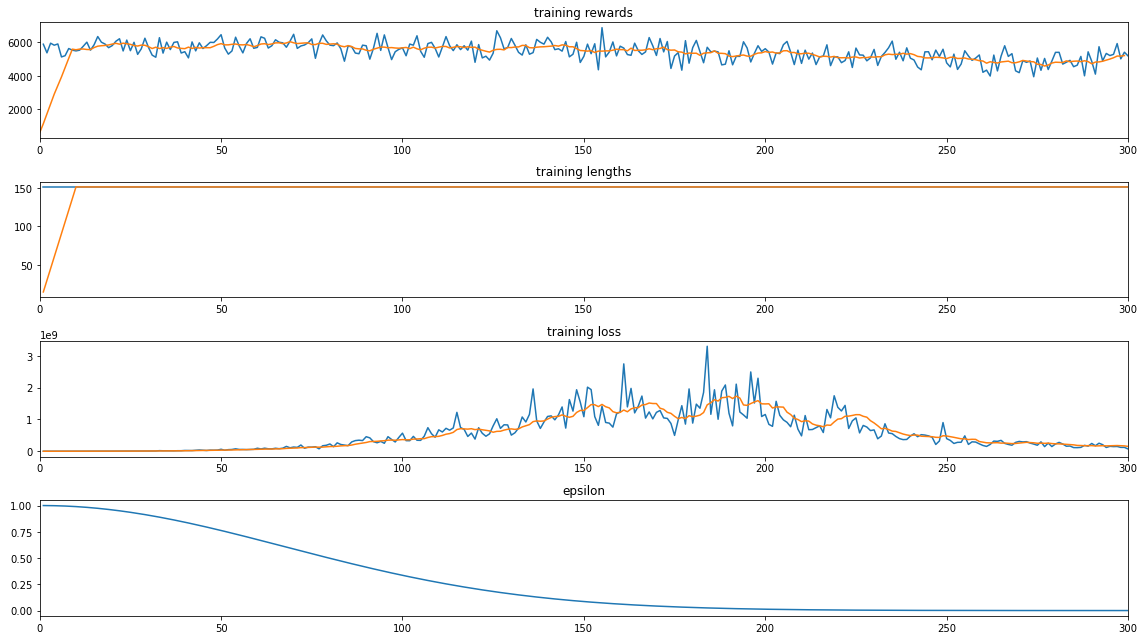

In [130]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

num_episodes = i +1
plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

In [108]:
def plot_choices(reward_list, tp_list, action_list, start, end):
    fig, ax = plt.subplots(dpi=200, figsize=(15,3))

    ax.bar(range(start,end), reward_list, label='reward')
    ax.bar(range(start,end), -4 * (np.array(tp_list) > 1), label='transfer_penalty')

    ax.scatter(range(start,end), (np.array(action_list) * 5) + 130, label='action')

    plt.xticks(np.arange(start, end, 1), range(start, end), fontsize=5, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(alpha=0.1, c='lightgray')

    #for i in range(130, 130+76*5, 5):
    #    ax.axhline(i, linewidth=0.5, c='lightgray')

    ax.set_ylabel('          Total Points          Action     ')
    ax.legend(bbox_to_anchor=(0.0, 1.02, 1., .102), loc='upper left',
                          ncol=3, mode="shrink", borderaxespad=0., fontsize=10, frameon=False)
    ticks = [tick for tick in plt.gca().get_yticks() if tick <=120]
    ax.set_xlabel(f"\ntotal reward: {np.sum(reward_list)}")
    plt.gca().set_yticks(ticks)
    plt.show()

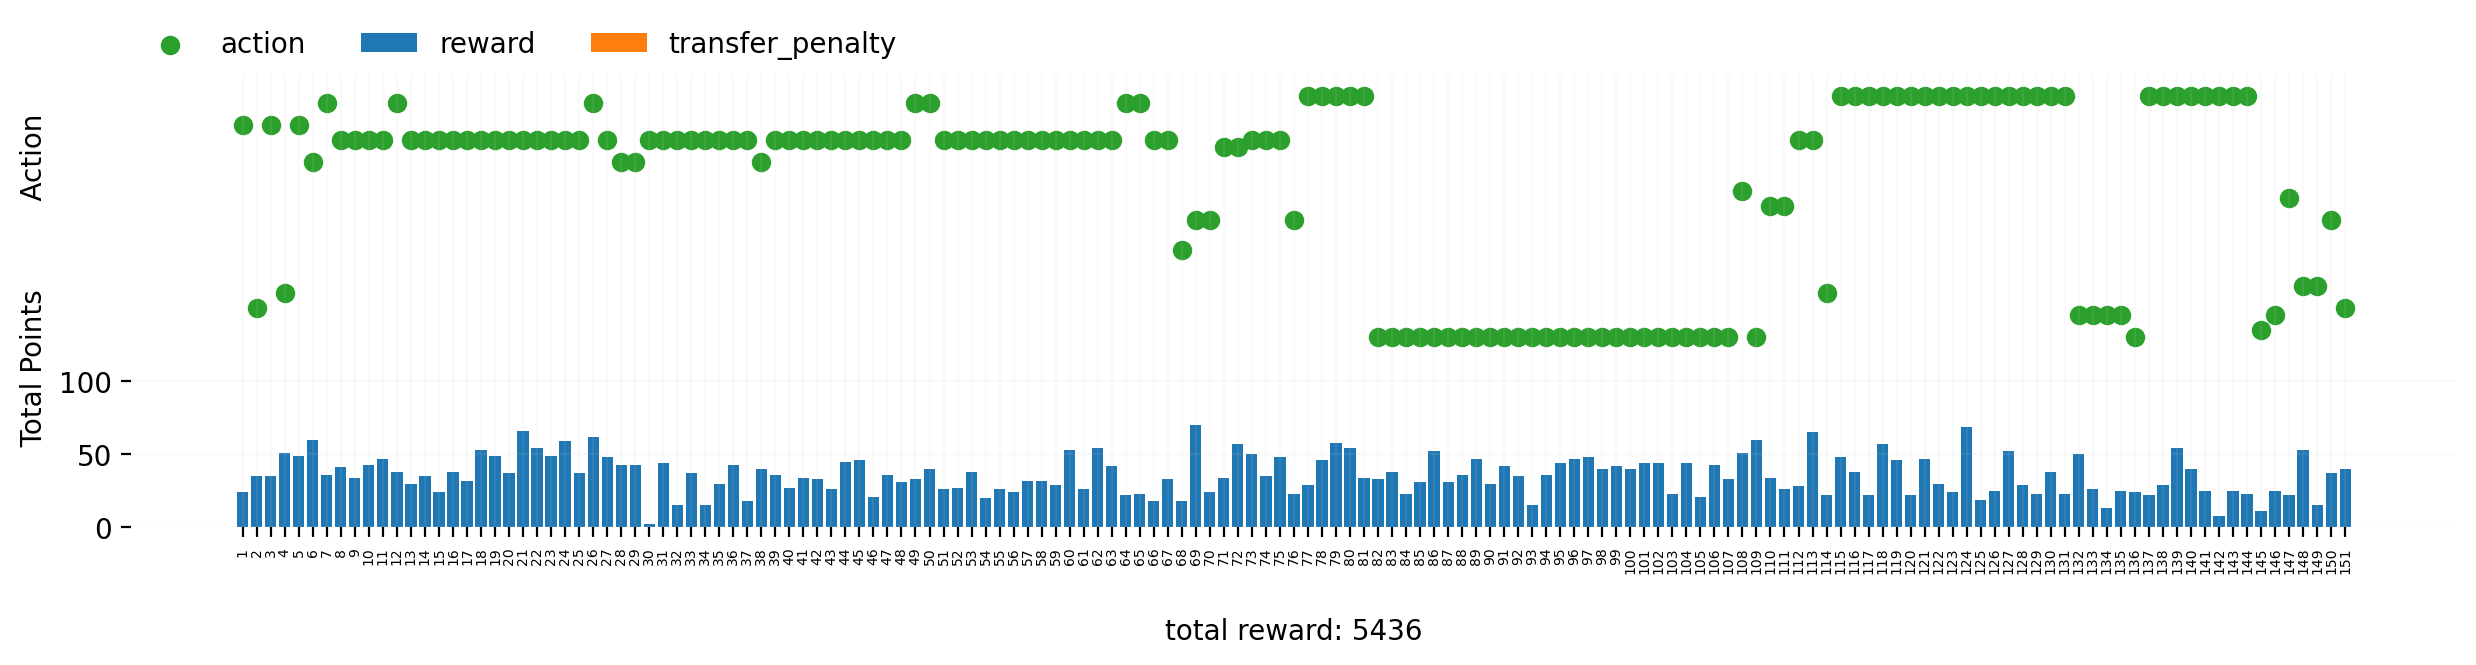

In [131]:
actions = {i: None for i in range(38)}
squads = [t]
reward_list = []
action_list = []
tp_list = []

start = 1
end = 152

s0, t = env.reset(start)

for j in range(start, end):
    with torch.no_grad():
        a = target_dqn(torch.from_numpy(s0.encoding).float().to(device)).argmax().item()
    action = env.action_space[a]
    s0, r, done, tp = env.step(a, metric='MA10')
    actions[j] = [a, r, tp]
    reward_list.append(r)
    action_list.append(a)
    tp_list.append(tp)
    squads.append(s0.team)
    if done: break
        

squads = np.array(squads)
plot_choices(reward_list, tp_list, action_list, start, end)